**<h1>Identifying Inappropriate Table of Surgical Procedures (TOSP) Pair Codes with Non-negative matrix factorization (NMF)</h1>**

<p align="justify">
In this notebook, we explore Non-Negative Matrix Factorization (NMF) to analyse TOSP code descriptions and identify inappropriate code pairs. Previously, we investigated three different clustering methods, but these approaches had limitations in accurately grouping semantically similar procedures. To improve our methodology, we introduce NMF for topic modeling and Agglomerative Clustering for hierarchical grouping.

---

## **1. Import Libraries and Setup**

Import the necessary libraries to set up the notebook.

In [32]:
# Import the required libraries
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Download Natural Language Toolkit (NLTK)
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **2. Data Loading and Pre-processing**

Loading the TOSP dataset (combined_dataset.csv) and applying the following pre-processing steps to enhance text quality:

* Convert text to lowercase - standardises input
* Removes numbers and punctuation reduces noise
* Removes stopwords - eliminates common but unimportant words
* Apply lemmatisation - reduces words to their base form for better clustering
* Trim extra spaces - removing unintended multiple spaces

<p align="justify">After preprocessing, we use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the cleaned descriptions into numerical representations. This technique assigns higher weights to important words determined by term frequency (TF) — <i>How many times does this word appear in this document among the number of times all words appear in this document? and <i>Inverse Document Frequency (IDF) — <i>How common (or uncommon) is this word among all the documents I have?</i>

---

In [33]:
# Loading the data (combined_dataset.csv)
df_tosp = pd.read_csv("combined_dataset.csv")

# Data pre-processing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    words = text.split()

    # Remove stopwords first
    words = [word for word in words if word not in stop_words]

    # Lemmatization after stopword removal
    words = [lemmatizer.lemmatize(word) for word in words]

    # Trim extra spaces
    return " ".join(words).strip()

df_tosp["Cleaned_Description"] = df_tosp["Description"].apply(preprocess_text)

# Display first 3 samples of the processed descriptions
print("\nSample of cleaned descriptions:")
for i, text in enumerate(df_tosp["Cleaned_Description"].head(3)):
    print(f"Original: {df_tosp['Description'].iloc[i][:100]}...")
    print(f"Cleaned: {text[:100]}...")
    print("-" * 50)


Sample of cleaned descriptions:
Original: BOTULINUM TOXIN THERAPY FOR MOVEMENT DISORDERS...
Cleaned: botulinum toxin therapy movement disorder...
--------------------------------------------------
Original: BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILATERAL)...
Cleaned: breast ductal lesion microdochectomy bilateral...
--------------------------------------------------
Original: BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILATERAL)...
Cleaned: breast ductal lesion microdochectomy unilateral...
--------------------------------------------------


In [34]:
# Extract descriptions and vectorize them using TF‑IDF
descriptions = df_tosp["Cleaned_Description"].tolist()
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(descriptions)

## **3. Finding the best "n_components" for NMF with Explained Variance (SVD)**

<p align="justify"> To determine the optimal number of components (`n_components`) for Non-Negative Matrix Factorization (NMF), we use Explained Variance via Singular Value Decomposition (SVD). This method helps identify the number of components that retain the majority of the dataset's information while reducing dimensionality.

<p align="justify">
By applying Truncated SVD, we compute the cumulative explained variance across different numbers of components. The ideal n_components is chosen where the cumulative variance reaches around 90% and 95%, to ensure that we capture the most important features while avoiding unnecessary complexity.

---

🔹 Number of components needed to reach 90% variance: 899
🔹 Number of components needed to reach 95% variance: 1149


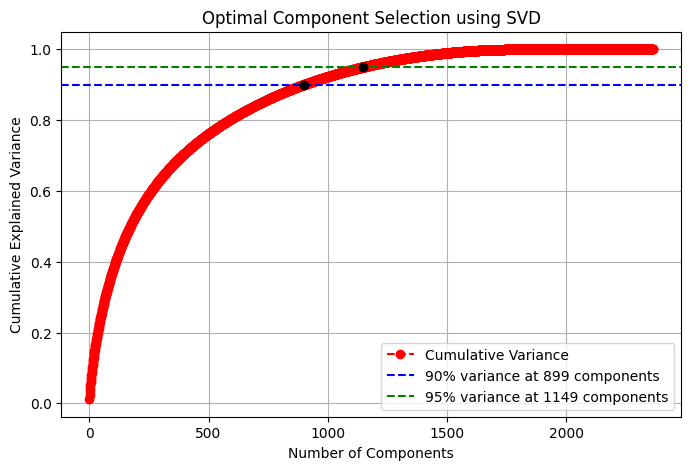

In [35]:
# Apply Truncated SVD
svd = TruncatedSVD(n_components=2364, random_state=42)
svd.fit(X)
explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Find the first index where cumulative variance reaches 90% and 95%
n_90 = np.argmax(explained_variance >= 0.90) + 1  # +1 because Python indexing starts at 0
n_95 = np.argmax(explained_variance >= 0.95) + 1

# Print the results
print(f"🔹 Number of components needed to reach 90% variance: {n_90}")
print(f"🔹 Number of components needed to reach 95% variance: {n_95}")

# Plot Cumulative Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 2364), explained_variance, marker="o", linestyle="--", color="red", label="Cumulative Variance")
plt.axhline(y=0.90, color="blue", linestyle="--", label=f"90% variance at {n_90} components")
plt.axhline(y=0.95, color="green", linestyle="--", label=f"95% variance at {n_95} components")

# Highlight the selected components
plt.scatter([n_90, n_95], [0.90, 0.95], color="black", zorder=3)

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Optimal Component Selection using SVD")
plt.legend()
plt.grid(True)
plt.show()

<p align="justify">
When applying SVD to determine the optimal number of components for NMF, we analysed the cumulative explained variance across different component values. The results indicate that 899 components are required to capture 90% of the variance, while 1149 components are needed to retain 95% of the dataset's information.

<p align="justify">
A significant number of components are necessary to preserve most of the variance in the TOSP descriptions. Based on these results, we've decided to use 1149 components, as reducing the number further could lead to a loss of critical information, which is essential for accurate clustering and similarity analysis.

## **4. Applying NMF and Agglromorative Clustering to dataset**

<p align ="justify">
The KMeans model was trained using the optimal parameters identified in our analysis. Since we do not have access to medical professionals for validation, our evaluation relies on manual inspection. Specifically, we assess similarity by identifying repeated keywords—such as "cataract surgery"—in the TOSP code descriptions to determine whether code pairs should be considered similar or different.

---

In [36]:
n_components = 1149  # Based on explained variance
nmf_model = NMF(n_components=n_components, random_state=42)
W = nmf_model.fit_transform(X)  # Document-topic matrix

# --- Apply Agglomerative Clustering ---
n_clusters = 1800  # Adjust based on exploration
agg_model = AgglomerativeClustering(n_clusters=n_clusters, linkage="average", metric="cosine")
agg_labels = agg_model.fit_predict(W)

# Assign cluster labels to DataFrame
df_tosp["Agglomerative_Cluster"] = agg_labels

# --- Step 5: Function to Compute Similarity & Cluster Assignments ---
def check_nmf_agg_similarity(code1, code2, df, W):
    """
    Compares two TOSP codes based on their NMF-transformed cosine similarity and cluster assignment.

    Parameters:
    - code1, code2: The TOSP codes to compare.
    - df: DataFrame containing the TOSP codes and descriptions.
    - W: NMF-transformed document-topic matrix.

    Returns:
    - Cosine similarity score and cluster assignments.
    """
    idx1 = df.index[df["Code"] == code1].tolist()
    idx2 = df.index[df["Code"] == code2].tolist()

    if not idx1 or not idx2:
        print(f"❌ One or both codes ({code1}, {code2}) not found in dataset.")
        return None

    vec1 = W[idx1[0]].reshape(1, -1)
    vec2 = W[idx2[0]].reshape(1, -1)

    sim_score = cosine_similarity(vec1, vec2)[0][0]

    cluster1 = df.loc[idx1[0], "Agglomerative_Cluster"]
    cluster2 = df.loc[idx2[0], "Agglomerative_Cluster"]

    same_cluster = cluster1 == cluster2

    print(f"Comparison: {code1} vs {code2}**")
    print(f"Cosine Similarity: {sim_score:.4f}")
    print(f"Agglomerative Clustering -> {code1}: Cluster {cluster1}, {code2}: Cluster {cluster2}")
    print(f"Same Cluster? {'Yes' if same_cluster else 'No'}")

    return sim_score, same_cluster

# --- Step 6: Example Comparisons ---
check_nmf_agg_similarity("SL701L", "SL702L", df_tosp, W)  # Similar codes
check_nmf_agg_similarity("SL701L", "SL705O", df_tosp, W)  # Different codes

Comparison: SL701L vs SL702L**
Cosine Similarity: 0.4180
Agglomerative Clustering -> SL701L: Cluster 1626, SL702L: Cluster 446
Same Cluster? No
Comparison: SL701L vs SL705O**
Cosine Similarity: 0.0000
Agglomerative Clustering -> SL701L: Cluster 1626, SL705O: Cluster 39
Same Cluster? No


(0.0, False)

## **6. Saving the NMF + Agglomerative Clustering**

<p align="justify">
To avoid retraining, we save the trained KMeans NMF + Agglomerative Clustering model using joblib. This allows us to reuse them later without recomputing clusters.

---

In [37]:
import joblib

# Save NMF + Agglomerative model
joblib.dump(agg_model, "NMF_Agglomerative_Model.pkl")

print("NMF + Agglomerative model saved successfully!")

NMF + Agglomerative model saved successfully!


## **7. Conclusion and Suggestions Moving Forward**

<p align="justify">
Our testing reveals that Agglomerative Clustering (with 1800 clusters) combined with NMF (using 1149 components) provides a structured approach to grouping TOSP codes. By using hierarchical clustering with dimensionality reduction, we aimed to improve cluster coherence and better capture relationships between procedure descriptions. While the model has shown improvements over previous methods, further evaluation is needed to determine its overall effectiveness.

<p align="justify">
In the final notebook, we will compare the results across all tested models, analysing their performance in identifying inappropriate TOSP code pairs. This will help determine which approach is the most effective for this task

---